# Investigating the GNU Octave mailing-list activity

> *Nov 01, 2019 — Kai T. Ohlhus &lt;<k.ohlhus@gmail.com>&gt; — [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/)*

This Jupyter-Octave-Notebook is inspired by the
[opening talk](https://indico.cern.ch/event/626097/contributions/2902420/attachments/1615292/2566811/2018-03-12-octave.pdf)
of John W. Eaton at the [OctConf 2018](https://wiki.octave.org/OctConf_2018)
at CERN in Geneva, Switzerland.
The outline is as follows:

1. [Crawl](https://en.wikipedia.org/wiki/Web_crawler) the Octave mailing-list
   archives at *gnu.org* to get the number of emails per month.
2. Present the data graphically.
3. Show a correlation between peaks in mailing-list and Octave releases.

A selection of utilized functions and links to the Manual are given in the
[final section](#Final-remarks).

## Define investigation parameter

In [1]:
base_url = "https://lists.gnu.org/archive/html";
lists    = {"help-octave", "octave-maintainers", "octave-bug-tracker"};
[this_year, ~] = datevec (now ());
years          = 1992:this_year;

## Getting data from gnu.org

Basically, the Octave mailing-list archives at *gnu.org* are only crawled on the
first run of this Notebook.
The results are cached in a file `mailing_list_activity.mat`.
On a usual PC with moderate fast internet connection,
running this section for the first time takes about **25 minutes**
for $3 \times 28 \times 12 = 1008$ (partially unneccesary) web requests.
This makes about 0.67 requests per second and there is lots of potential for improvment,
which will not be addressed here.

According to the current implementation of the mailing-list archives,
a sequence of URLs
* https://lists.gnu.org/archive/html/help-octave/1993-01
* https://lists.gnu.org/archive/html/help-octave/1993-02
* ...

is generated.
The repective page source code is read into a string by `urlread`.
Finally, in that string an email is counted by finding a starting HTML `<li>`- and `<a>`-tag.

In [2]:
data_file = "mailing_list_activity.mat";
if (exist (data_file, "file") == 2)
  load (data_file, "activity");     # Use cache if possible
else
  M = length (lists);
  N = length (years);
  activity = zeros (M, N * 12);
  tic;
  for i = 1:M           # For all mailing-lists
    list_url = sprintf ("%s/%s/", base_url, lists{i});
    for j = 1:N         # For each year
      for month = 1:12  # For each month
        tick = sprintf ("%d-%02d", years(j), month)
        try
          html = urlread ([list_url, tick]);
          activity(i, (j-1)*12 + month) = length (strfind (html, "<li><a"));
        catch
          printf ("  No data for %s.\n", tick);
        end_try_catch
      endfor
    endfor
  endfor
  elapsed_time = toc
  save (data_file, "activity");
endif

To get an idea of the data, one can easily display a portion of it.
Using the statement below, the data for **July to December** of the **current year** is shown.
The first row displays a numeric value for the month.
The second to last row show the number of emails of the respective mailing-lists
*help-octave@gnu.org*, *octave-maintainers@gnu.org*, and *octave-bug-tracker@gnu.org*.
As expected, there is no data for November and December available yet.

In [3]:
disp ([7:12; activity(:,end-5:end)])

     7     8     9    10    11    12
   171   178   143   296     0     0
    65    87    98   172     0     0
   372   341   429   649     0     0


## Present the data graphically

["A picture is worth a thousand words"](https://en.wikipedia.org/wiki/A_picture_is_worth_a_thousand_words).
This is often true in science, as well.
Presenting data graphically sometimes reveals patterns that are not obvious from the bare figures.
GNU Octave has many built-in functions to do this.
A bare minimum of necessary code to visualize the `activity`-matrix might be:

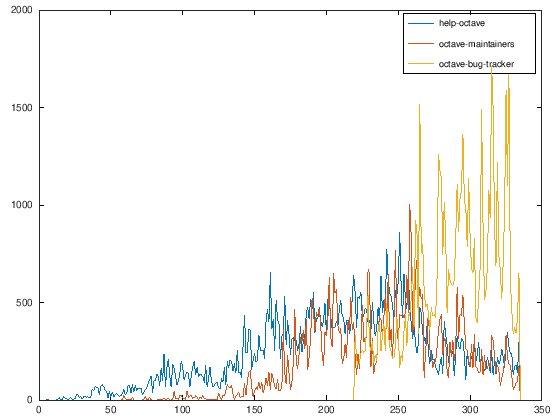

In [4]:
x_ticks = 1:size (activity, 2);
plot (x_ticks, activity(1,:), ...
      x_ticks, activity(2,:), ...
      x_ticks, activity(3,:))
legend (lists);

To tune the figure for a publication, the following modifications are performed:

1. Smoothing the graphs by applying a five-month
   [moving average](https://en.wikipedia.org/wiki/Moving_average).
   Note, that this operation also removes peak values, like `activity_max`.

In [5]:
activity_max = max (max (activity))
activity     = movmean (activity, 5, 2, "endpoints", "shrink");

activity_max =  1710


2. Increasing the line width.

In [6]:
set (0, "DefaultLineLineWidth", 4);

3. Creating a meaningful x-axis consisting of date values.
   This is done in combination with the `datetick("x")` function.

In [7]:
x_ticks = arrayfun (@(x,y) datenum(x, y, 01), ...
                           repelem(years, 12), ...
                           repmat(1:12, 1, length (years)));

4. Changing the graph colors,
   increasing the font sizes,
   reposition the legend, and
   add verbose axis labels.
   Finally, the figure is printed (exported) to a PNG-image.

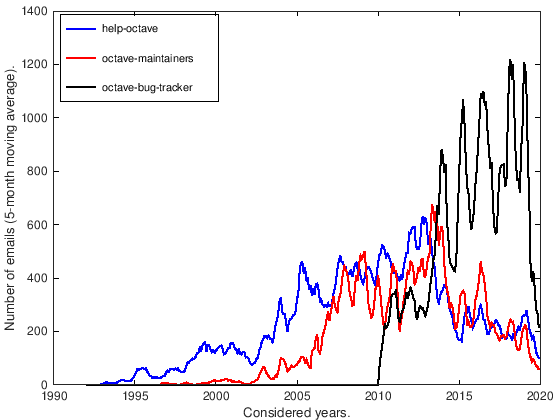

In [8]:
plot (x_ticks, activity(1,:), "b", ...
      x_ticks, activity(2,:), "r", ...
      x_ticks, activity(3,:), "k");
datetick ("x");
set (gca (), "FontSize", 12);
legend (lists, "location", "northwest");
xlabel ("Considered years.");
ylabel ("Number of emails (5-month moving average).");

print -dpng mailing_list_activity

## Correlation to Octave releases

Especially the [Octave bug tracker](https://savannah.gnu.org/bugs/?group=octave),
launched in 2010, shows a very striking wave pattern.
John W. Eaton gave an explanation, by looking at the dates of
[Octave releases](https://wiki.octave.org/Release_History).

In [9]:
x = [datenum(2019, 02, 23), ... # 5.1.0
     datenum(2018, 04, 30), ... # 4.4.0
     datenum(2016, 11, 13), ... # 4.2.0
     datenum(2015, 05, 23), ... # 4.0.0 (GUI)
     datenum(2013, 12, 27)];    # 3.8.0

To get a better impression, one can shrink the considered years from 2010 to this year

In [10]:
idx = find (activity(3,:), 1):length (x_ticks);
max_val = max( max (activity));

and mark the release dates:

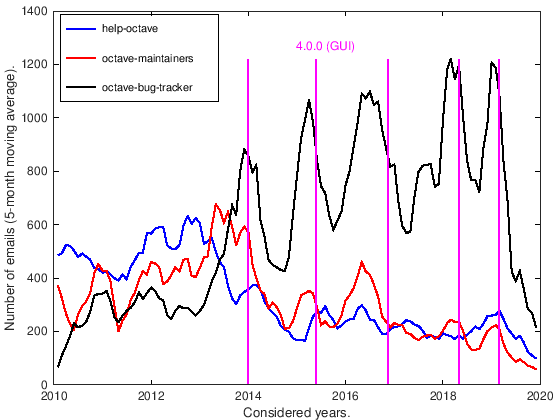

In [11]:
plot (x_ticks(idx), activity(1,idx), "b", ...
      x_ticks(idx), activity(2,idx), "r", ...
      x_ticks(idx), activity(3,idx), "k");
datetick ("x");
set (gca (), "FontSize", 12);
legend (lists, "location", "northwest");
xlabel ("Considered years.");
ylabel ("Number of emails (5-month moving average).");

hold on;
plot (repmat (x, 2, 1), ...
      repmat ([0; max_val], 1, length (x)), "m");
text (x(4) - 150, max_val + 50, "4.0.0 (GUI)", ...
      "color", "magenta", "fontsize", 12);

A possible explanation goes like this:
* Before an Octave release happens, there usually is an
  [announcement](https://lists.gnu.org/archive/html/octave-maintainers/2018-12/msg00000.html)
  on *octave-maintainers@gnu.org*.
* Now people want their open bugs to be resolved even sooner.
* After the release happened, some regressions reveal,
  as the new release is now tested on many many more systems and configurations,
  than before.

## Final remarks

A selection of utilized functions and links to the Manual:

* `arrayfun()`
  https://octave.org/doc/v5.1.0/Function-Application.html
* `legend()`, `plot()`
  https://octave.org/doc/v5.1.0/Two_002dDimensional-Plots.html and
  https://octave.org/doc/v5.1.0/Graphics-Object-Properties.html
* `set(0, ...)`
  https://octave.org/doc/v5.1.0/Managing-Default-Properties.html
* `urlread()`
  https://octave.org/doc/v5.1.0/Networking-Utilities.html
* `load()`, `save()`
  https://octave.org/doc/v5.1.0/Simple-File-I_002fO.html
* `movmean()`
  https://octave.org/doc/v5.1.0/Statistics.html
* `tic .. toc`, `datenum()`, `datetick()`, `datevec()`, `now()`
  https://octave.org/doc/v5.1.0/Timing-Utilities.html